# 🍿 ML with Python - Clustering

One use-case for clustering would be customer segmentation e.g. targeting a specific group of customers to allocate marketing resources (more likely to purchase products/subscribe to a service)

Once you find a group/segment, you can join each entry in the dataframe with that respective classification.

#### Definition

**Clustering** means finding clusters in a dataset, unsupervised

So a **cluster** is a group of data point or objects in a dataset that are similar to other objects in the group, and dissimilar to data points in other clusters.

*What is different  between clustering and classification?*

Classification means the prediction of categorical class labels. It has supervised learning approaches like trees, SVM, logReg, etc.

Clustering has data that is unlabelled and the process is unsupervised. So a clustering algorithm like **k-means** can group similar data points based on their similar attributes.

### Applications

Retail/Marketing:
* Identifying buying patterns of customers
* Recommending new books or movies to customers

Banking:
* Fraud detection in credit card use
* Identifying clusters of customers e.g. loyal vs churn

Insurance:
* Fraud detection in claims analysis

Publication
* Auto-categorizing news based on content
* Recommending similar news articles

Medicine
* Characterizing patient behavior

Biology
* Grouping genes with similar expression patterns
* Finding family ties

* EDA
* Summary generation
* Outlier detection
* Finding duplicates
* Pre-processing step

### Various Clustering Algorithms

#### Partition-based clustering

Relatively efficient. Includes k-means, k-median, fuzzy c-means. Usually used to separate data into spheres/circles

#### Hierarchical Clustering

Produces trees of clusters.
Includes Agglomerative and diverse algorithms. This group of algorithms is very intuitive and is generally good for use with small-sized datasets.

#### Density-based Clustering

Produce arbitrary shaped clusters. They are especially good when dealing with spatial clusters or when there is noise in a dataset. e.g. DBScan algorithm

### K-Means Clustering

Can group data only "unsupervised" based on the similarity of datapoints to eachother.

A type of **Partitioning Clustering**. Divides the data into non-overlapping subsets (clusters) without any cluster-internal structure

Tries to maximize the distance between clusters while miniimizing the distance between points within the clusters.

Often this distance is done by calculating the **Euclidean Distance** for however many dimensions we are looking at.
* Important that the feature-set is normalized beforehand since distance is being used

Also **cosine similarity** and **average distance** can be used.

First Step: Initizlize ```k``` (number of clusters) centroids randomly.
These centroids are the center of each prospective cluster.
* We can initially choose observations from the dataset to use as these centroids
* Can also choose 3 random points

**Second Step**: Distance Calculation:
Calculate the distance from each of the centroids for each of the points. This forms a matrix (the distance matrix) that has the distane of each point from each centroid e.g. 

$ C_{1}, C_{2}, C_{3} $

$ [d(p1, c1), d(p1, c2), d(p1, c3)]$

Once the closest centroid has been selected for each datapoint, we can calculate the error and see how well each cluster represents the points.

**Third Step** Assign each point to closest centroid

**Fourth Step** - Compute the new centroids for each cluster. Often each cluster centroid will be updated to the mean of the data points for the cluster.

**Fifth Step** repeat until there are no more changes - clusters with minimum error.

The errir is given as the sum of squares error:

$SSE = \sum_{1}^{n}(x_{i}-C_{j})^2$

* No guarantee that it will converge to the global optimum. The result may depend on the initial clusters. The result of convergence **could** be a local error minimum
* Often to solve this problem, it is common to run the whole process multiple times with different starting conditions
* This also generally means that it is best to start with random centroids

#### 🧑‍🍳 Implementing K-Means from Scratch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./IRIS.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [2]:
df.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

For this example, I chose the **petal_width** and **petal_length** features because they offer some nice data clusters to illustrate the algorithm with.

In [3]:
features = [
    'petal_width',
    'petal_length',
]

len(df)

150

Before running K-means, because the algorithm uses a distance function (in this case *Euclidean Distance*), the features need to be scaled - else the algorithm will converge the Sum of Squares error to bias features with larger distributions.

In [4]:
# Standard scaling on features
for feature in df[features]:
    df[feature] = (df[feature] - df[feature].mean())/ df[feature].std()

The following class implements a k-means algorithm from scratch. 
* The algorithm allows for ```random``` and ```forgy``` centroid initialization. We note that K++ is often accepted as the superior initialization method.
* The algorithm can take any value of ```k```
* Distance is calculated as ```Euclidean Distance```
* Error is calculated as the ```Sum of Squares Error```
* New centroids are updated as the mean of their current cluster.
* Convergence $\sigma$ is set to ```1```

There are lots of different configurations of the algorithm that can be updated from this

I note that this algorithm isn't perfect: there are some edge cases that haven't been ran yet (like asserting a centroid cannot be empty from points and preventing 0 division), and the numpy calculations can certainly be made more elegant.

In [5]:
import numpy as np

class k_means():

    possible_centroid_initializations = ['random', 'forgy',]
                                        #  'k++', ]

    k = 3
    distance = np.empty(0)
    centroids = np.empty(0)
    data = np.empty(0)
    errors = []
    prev_centroids = []
    prev_centroid_points = []
    centroid_points = np.empty(0)
    centroid_initialization = "random"

    # Sets k, initializes empty centroids and distance matrix
    def __init__(self, k = 3, centroid_initialization = "random"):
        self.k = k
        self.centroids = np.empty(k, dtype=object)
        self.centroid_initialization = centroid_initialization
        if self.centroid_initialization not in self.possible_centroid_initializations:
            raise Exception("Please specify a possible centroid initialization method: ", self.possible_centroid_initializations)

    def fit(self, data):
        sigma = 1

        self.data = data
        self.centroid_points = np.empty(len(data))
        # Initialize an empty distance matrix
        self.distance = np.empty(len(data), dtype=object)
        for i in range(len(self.distance)):
            self.distance[i] = np.array(np.empty(self.k))

        self.initialize_centroids()
        while True:
            self.calculate_distance()
            self.assign_centroids()
            self.calculate_error()
            self.update_centroids()

            # Check for convergence
            if len(self.errors) > 1:
                if abs(self.errors[-1] - self.errors[-2]) <= sigma:
                    self.prev_centroids.append(self.centroids)
                    self.prev_centroid_points.append(self.centroid_points)
                    break
        
    def initialize_centroids(self):
        if self.centroid_initialization == 'random':
            # Choose a random point between each value in the data
            for i in range(self.k):
                self.centroids[i] = np.array(np.empty(len(self.data.columns)))
                for idx, col in enumerate(self.data.columns):
                    x = np.random.uniform(low = self.data[col].min(), high = self.data[col].max())
                    self.centroids[i][idx] = x
        elif self.centroid_initialization == 'forgy':
            # Choose a random point for the data
            for i in range(self.k):
                # Check for edge case of fewer edge cases than clusters
                if len(self.data) <= self.k:
                    raise Exception("Error: cannot perform forgy centroid initialization for fewer observations than centroids")
                observation_indices = []
                self.centroids[i] = np.array(np.empty(len(self.data.columns)))
                # Generate unique centroids from random observations
                while True:
                    random_index = np.random.randint(0, len(self.data))
                    random_observation = self.data.iloc[random_index].values
                    if random_index not in observation_indices:
                        self.centroids[i] = random_observation
                        break

    # Calculates euclidean distance between observations and centroids
    def calculate_distance(self):
        for j in range(self.k):
            for idx, row in self.data.iterrows():
                distance = 0
                distance = np.sqrt(sum((row.values-self.centroids[j])**2))
                self.distance[idx][j] = distance

    # Assigns each observation to the nearest centroid based on the distances computed
    def assign_centroids(self):
        for i in range(len(self.distance)):
            self.centroid_points[i] = np.argmin(self.distance[i])

    # Gets the SSE from points within the centroids, saves previous errors, centroids, and cluster mappings for visualization
    def calculate_error(self):
        error = 0
        for idx, row in self.data.iterrows():
            error = error + (row.values - self.centroids[int(self.centroid_points[idx])])**2
        error = sum(error)
        self.errors.append(error)
        self.prev_centroids.append(self.centroids)
        self.prev_centroid_points.append(self.centroid_points.copy())

    # Sets the centroids to the mean value of each cluster's points
    def update_centroids(self):
        # Initialize empty centroids for updating
        centroid_count = np.empty(self.k)
        updated_centroids = np.empty(self.k, dtype=object)
        for i in range(self.k):
            centroid_count[i] = 0
            updated_centroids[i] = np.array(np.empty(len(self.data.columns)))
            for j in range(len(self.data.columns)):
                updated_centroids[i][j] = 0
        # Go through and sum up the points 
        for idx, row in self.data.iterrows():
            centroid_idx = int(self.centroid_points[idx])
            updated_centroids[centroid_idx] = updated_centroids[centroid_idx] + row.values
            centroid_count[centroid_idx] = centroid_count[centroid_idx] + 1
        # Now divide to get the mean values
        for i in range(self.k):
            updated_centroids[i] = updated_centroids[i] / centroid_count[i]
        self.centroids = updated_centroids

    def get_centroids(self):
        return self.prev_centroids

    def get_centroid_points(self):
        return self.prev_centroid_points


# Initialize and fit a k means, getting some metadata for visualization
km = k_means(3, centroid_initialization="forgy")
km.fit(df[features])
c = km.get_centroids()
pts = km.get_centroid_points()

The below cell will output the population of each cluster - used in debugging the visualization

In [6]:
# for i in range(len(pts)):
#     print(pd.DataFrame(np.array(pts[i])).value_counts())

The below cell is used for visualization of the K-means algorithm as the centroids move and the clusters are updated.

There are more elegant ways to code the function to handle $k\neq{3}$, which is currently hard-coded along with data of dimensions $d \neq{2}$, but the idea is simply to perform some basic visualization.

/var/folders/4f/6c2p53ln64s21k6dzcxg0hj00000gn/T/ipykernel_38821/2172867140.py:53: UserWarning: frames=<generator object custom_frames at 0x1279e3040> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, func=update, frames=custom_frames(c), init_func=init, blit=False, interval=1000)


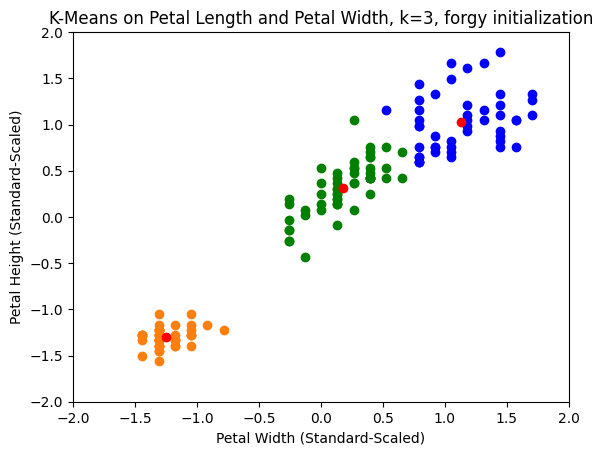

In [7]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
line, = ax.plot([], [], 'ro')
line_one, = ax.plot([], [], 'bo')
line_two, = ax.plot([], [], 'go')
line_three, = ax.plot([], [], 'C1o')
line, = ax.plot([], [], 'ro')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# Initialize function to set background of each frame
def init():
    line.set_data([], [])
    line_one.set_data([], [])
    line_two.set_data([], [])
    line_three.set_data([], [])

    return line, line_one, line_two, line_three


def update(frame):
    frame_idx, frame_data = frame

    frame_array = np.vstack(frame_data)

    xdata = frame_array[:, 0]
    ydata = frame_array[:, 1]

    df_one = df[features].copy()
    df_one['cluster'] = pts[frame_idx]
    
    xdata_df_one = df_one[df_one['cluster'] == 0.0][features[0]]
    ydata_df_one = df_one[df_one['cluster'] == 0.0][features[1]]
    line_one.set_data(xdata_df_one, ydata_df_one)

    xdata_df_two = df_one[df_one['cluster'] == 1.0][features[0]]
    ydata_df_two = df_one[df_one['cluster'] == 1.0][features[1]]
    line_two.set_data(xdata_df_two, ydata_df_two)

    xdata_df_three = df_one[df_one['cluster'] == 2.0][features[0]]
    ydata_df_three = df_one[df_one['cluster'] == 2.0][features[1]]
    line_three.set_data(xdata_df_three, ydata_df_three)

    line.set_data(xdata, ydata)

    return line, line_one, line_two, line_three

def custom_frames(data):
    for idx, frame in enumerate(data):
        yield idx, frame

ani = FuncAnimation(fig, func=update, frames=custom_frames(c), init_func=init, blit=False, interval=1000)
plt.title("K-Means on Petal Length and Petal Width, k=3, forgy initialization")
plt.xlabel("Petal Width (Standard-Scaled)")
plt.ylabel("Petal Height (Standard-Scaled)")
ani.save('k_means_3_euclidean_iris.mp4', writer='ffmpeg')
plt.show()

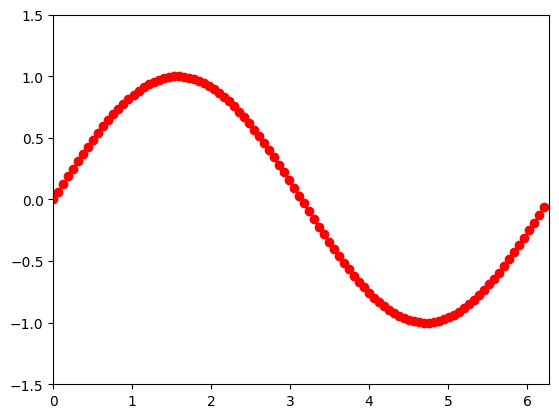

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Generating some simple data
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

fig, ax = plt.subplots()
line, = ax.plot([], [], 'ro-')  # Initialize a line plot
ax.set_xlim(0, 2*np.pi)  # Set x-axis limits
ax.set_ylim(-1.5, 1.5)  # Set y-axis limits

def init():
    line.set_data([], [])
    return line,

def update(frame):
    line.set_data(x[:frame], y[:frame])
    return line,

ani = FuncAnimation(fig, update, frames=len(x), init_func=init, blit=True, interval=50)
ani.save('animation.mp4', writer='ffmpeg')

plt.show()

$SSE = \sum_{1}^{n}(x_{i}-C_{j})^2$


In [9]:
# Actual values
actual = np.array([[10, 2, 1], [30, 4, 14]])

# Expected values
expected = np.array([[1, 1, 1], [2, 2, 2]])

# Calculate the differences
differences = actual - expected
print(differences)
print('-'*100)

# Square the differences
squared_differences = differences ** 2
print(squared_differences)
print('*'*100)

# Sum the squared differences
sse = np.sum(squared_differences)

print("Sum of Squares Error (SSE):", sse)

[[ 9  1  0]
 [28  2 12]]
----------------------------------------------------------------------------------------------------
[[ 81   1   0]
 [784   4 144]]
****************************************************************************************************
Sum of Squares Error (SSE): 1014


#### K-Means Accuracy

"*How can we evaluate the goodness of clusters formed?*"

This accuracy can be done by comparing the clusters with the ground truth if it's available (but because K-means is unsupervised this often isn't available).

But there is a way to say how 'bad' each cluster is, based on the objective of K-means.

Determining a value of ```k``` is often a big problem when running K-means. Often people just iterate through various values of k and look at a metric e.g.
* mean distance between data points and the cluster centroid. One issue with this is that when you increase the number of clusters, the distance of centroids will always reduce. So increasing K will always decrease the error. A way to pick a good value for ```k``` when using this metric is to graph the error and pick an "*elbow point*" where the rate of error decrease notably reduces. This is called the **elbow method**.